<a href="https://colab.research.google.com/github/joshbrx/biomath_model/blob/main/Voronoi_cells_prototipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Modelo de células con distribución espacial__

---

Import stantard libraries for plotting and necessary libraries from `SciPy`

In [41]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.collections import LineCollection

from matplotlib.patches import Polygon
import imageio                                          # create an animation (.gif)
import seaborn as sns

mycolor = mpl.colormaps["summer"].resampled(100)
mpl.rcParams['figure.figsize'] = (12,8)
plt.style.use('dark_background')

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
def vpoint_to_xy(vor, index):
    return vor.points[index]

def vpoint_to_region(vor, index):
    return vor.point_region[index]

def region_to_vpoint(vor, index):
    return np.where(vor.point_region == index)[0][0]

In [44]:
def vpoints_to_regions(vor, vpoints):
    regions = []
    for i in vpoints:
        regions.append(vpoint_to_region(vor, i))
    return regions

def regions_to_vpoints(vor, regions):
    vpoints = []
    for i in regions:
        vpoints.append(region_to_vpoint(vor, i))
    return vpoints

Ahora continuamos al definir las fronteras de nuestra superficie. Como queremos que se asemeje a una estructura acinar, utilizamos dos circunferencias con cortes a la mitad para dar una aproximación a la estructura.

\begin{align}
    \alpha(r, \theta, \varepsilon) = r,\qquad\ r=\{1, 2\}, \quad \theta\in{(0, \pi)}
\end{align}



---

En coordenadas cartesianas se tiene lo siguiente:

\begin{align}
    x &= r\cos\theta,\quad &y &= r\sin\theta\\
    \Rightarrow r &= \sqrt{x^2+y^2},\quad &\theta &= \arctan\left(\frac{y}{x}\right)
\end{align}

Por lo tanto, para el área entre las medias circunferencias se tiene

$$A_0 =\frac{\pi(r^2_{\max}-r^2_{\min})}{2}$$

Y finalmente al considerar los dos tramos rectangulares que conectan con la estructura de medias circunferencias concéntricas se tiene un área total $A_T$ daba por:

$$A_{T} = (r_{\max}-r_{\min})\left[\frac{\pi}{2}(r_{\max}+r_{\min})+2l\right]$$

In [45]:
def A_total(r, l, N, cols=1):
    A_sys = (r[1] - r[0])*(np.pi/2*(r[1] + r[0]) + 2*l)
    A_cells = A_sys * cols / (cols+1) * (N-1) / N
    return A_cells

A_total([1,2], 0, 10, cols=1)

2.1205750411731104

Ahora, al considerar a los parámetros $r_{max}$ y $r_{min}$ fijos ($l$ variable) se tiene que

$$ dA_T = \frac{(r_{max}-r_{min})}{1+ \text{# filas}} dl = \frac{A_T}{N}=\langle A_{cell} \rangle $$

Por lo tanto, se alargará $l$ en $l + dl$ en la siguiente proporción para el caso de una sola fila.

$$ dl = \frac{2\langle A_{cell} \rangle}{(r_{max}-r_{min})}$$

In [46]:
### funciones
def alpha_x(r, theta, d_theta=None):
    s = []
    if d_theta == None:
        for i in range(len(theta)):
            if (theta[i] < 0) or (theta[i] > np.pi):
                s.append(-theta[i]/abs(theta[i]) * r)
            else: s.append(r*np.cos(theta[i]))
    else:
        if (theta < 0) or (theta > np.pi):
            s.append(-theta/abs(theta) * r)
        else: s.append(r*np.cos(theta))
    return np.asarray(s)

def alpha_y(r, theta, d_theta=None):
    s = []
    if d_theta == None:
        for i in range(len(theta)):
            if (theta[i] < 0) or (theta[i] > np.pi):
                d_theta = theta[1] - theta[0]
                tmp = np.min(np.abs([theta[i], np.pi - theta[i]]))
                s.append(-r * tmp * 0.9)
            else: s.append(r*np.sin(theta[i]))
    else:
        if (theta < 0) or (theta > np.pi):
            tmp = np.min(np.abs([theta, np.pi - theta]))
            s.append(-r * tmp* 0.9)
        else: s.append(r*np.sin(theta))
    return np.asarray(s)

In [47]:
def half_donut(r, theta, n_space):
    X_border, Y_border = [], []
    X_border.append(np.concatenate((alpha_x(r[0], np.linspace(theta[0], theta[1], (3*n_space)//5)),
                                    alpha_x(r[1], np.linspace(theta[0], theta[1], n_space))), axis=0))
    Y_border.append(np.concatenate((alpha_y(r[0], np.linspace(theta[0], theta[1], (3*n_space)//5)),
                                    alpha_y(r[1], np.linspace(theta[0], theta[1], n_space))), axis=0))
    X_border = np.array(X_border).flatten(); Y_border = np.array(Y_border).flatten();
    donut = np.array([X_border, Y_border])
    return donut

def tunnels(r, l, l_div=0.1):
    X_tunnel, Y_tunnel = [], []
    n_tunnel = int(np.ceil(l/l_div))
    for i in range(2):
        X_tunnel.append(np.concatenate(( np.ones(n_tunnel)*r[i],
                                        -np.ones(n_tunnel)*r[i],
                                         np.linspace(r[0], r[1], num=10)*(-1)**(i)), axis=0))
        Y_tunnel.append(np.concatenate(( np.linspace(0,-l, num=n_tunnel),
                                         np.linspace(0,-l, num=n_tunnel),
                                        -np.ones(10)*l), axis=0))
    X_tunnel = np.array(X_tunnel).flatten(); Y_tunnel = np.array(Y_tunnel).flatten();
    tunnel = np.array([X_tunnel, Y_tunnel])
    return tunnel

def get_structure(r, theta, l, N):
    donut = half_donut(r, theta, N)
    tunnel = tunnels(r, l, l_div=0.1)
    structure = np.concatenate((donut, tunnel), axis=1)
    return structure

def rand_points(r, theta, l, N):          # Revisar parametro "l"
    X_rand, Y_rand = np.empty(N), np.empty(N)

    r_rand     = 0.5 * (r[-1]-r[0]) * (np.random.rand(N)-0.5) + np.mean(r)
    theta_tmp  = np.linspace(theta[0]-l/np.mean(r), theta[1]+l/np.mean(r))
    theta_rand = np.random.choice(theta_tmp, size=N)

    for i in range(N):
        X_rand[i] = alpha_x(r_rand[i], theta_rand[i], d_theta=theta[1]-theta[0]);
        Y_rand[i] = alpha_y(r_rand[i], theta_rand[i], d_theta=theta[1]-theta[0]);
    points_rand = np.array([X_rand, Y_rand])
    return points_rand

def org_points(r, theta, l, N):
    theta_org = np.linspace(theta[0]-l/np.mean(r)*(N+1)/N, theta[1]+l/np.mean(r)*(N+1)/N, num=N+2)[1:N+1]
    # theta_org = np.linspace(theta[0]-l/np.mean(r), theta[1]+l/np.mean(r), num=N+2)[1:N+1]
    X_org = alpha_x(np.mean(r), theta_org);
    Y_org = alpha_y(np.mean(r), theta_org);
    points_org = np.array([X_org, Y_org])
    return points_org

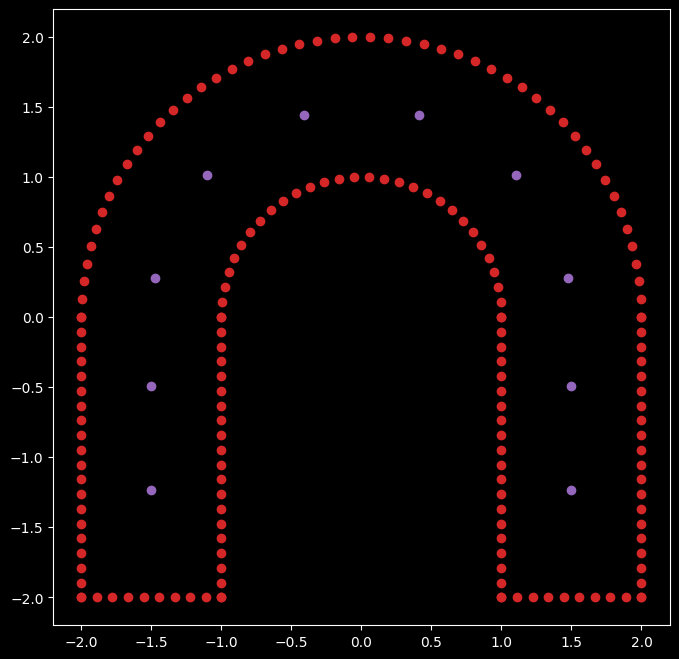

In [48]:
### parámetros
n_space = 50
theta = np.array([0, np.pi]);
r = np.array([1.0, 2.0]);

N = 10; l = 2
structure = get_structure(r, theta, l, n_space)
# points = rand_points(r, theta, l, N).T
points = org_points(r, theta, l, N).T

plt.scatter(points.T[0], points.T[1], color="tab:purple")
plt.scatter(structure[0], structure[1], color="tab:red")
plt.axis('scaled'); plt.show()

In [49]:
def mk_voronoi(points, pts_structure):
    total = np.concatenate((points, pts_structure.T))
    vor = Voronoi(total)
    return vor

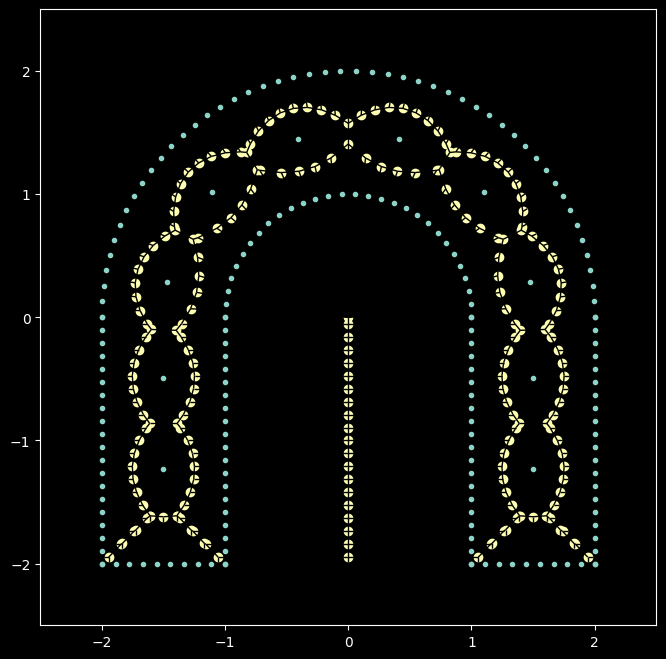

In [50]:
vor = mk_voronoi(points, structure)

voronoi_plot_2d(vor)
plt.axis("scaled")        # or plt.axis("equal")
plt.xlim([-2.5, 2.5]); plt.ylim([-2.5, 2.5])
plt.show()

*   ###  __Paso $N+1$:__ _Encontrando y discriminando las regiones de Voronoi_



(-2.5, 2.5)

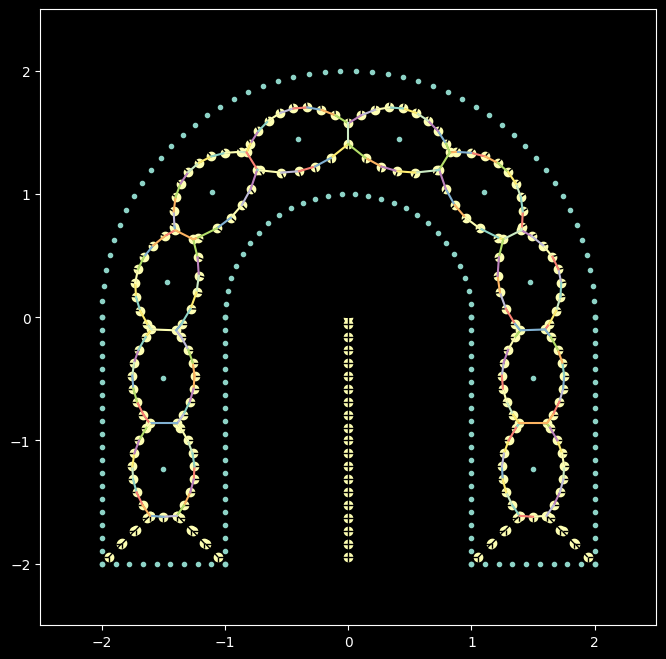

In [51]:
finite_segments = []
temp_dict = vor.ridge_dict
temp_keys = temp_dict.keys()

voronoi_plot_2d(vor)
plt.axis("scaled")        # or plt.axis("equal")

for key in temp_keys:
    if np.all(np.asarray(temp_dict[key]) >= 0) and np.any(np.asarray(key) < len(points)):
        finite_segments.append(vor.vertices[np.asarray(temp_dict[key])])

for i in range(len(finite_segments)):
    x_line = finite_segments[i][:,0]
    y_line = finite_segments[i][:,1]
    plt.plot(x_line, y_line)
    plt.axis("scaled")        # or plt.axis("equal")

plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])

In [52]:
def get_polygons(vor, N_points):
    Polygons, regions = [], []
    nregions = len(vor.regions)
    for i in range(len(vor.regions)):
        if (not -1 in vor.regions[i]) and (len(vor.regions[i]) >=1):
            polygon = np.array([vor.vertices[k] for k in vor.regions[i]])
            Polygons.append(np.array([*zip(*polygon)]))
            regions.append(i)
    vpoints = regions_to_vpoints(vor, regions)
    Polygons = [np.array(x) for _,x in sorted(zip(vpoints, Polygons))][:N_points]
    return Polygons

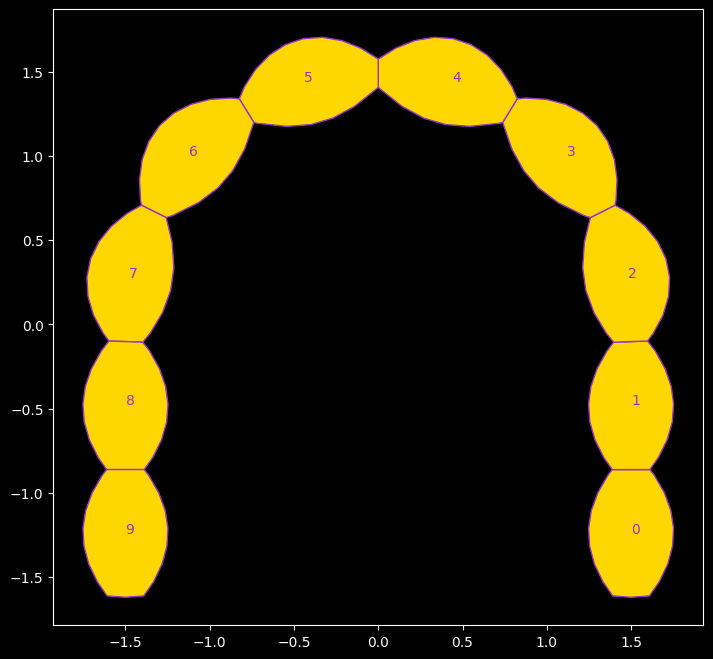

In [53]:
# points = rand_points(r, theta, N, tol=0.02).T                          # make up data points
vor = mk_voronoi(points, structure)                                 # compute Voronoi tesselation

Polygons = get_polygons(vor, N)                                  # get Voronoi regions

for i in range(len(Polygons)):                                          # visualize Voronoi regions
    polygon = Polygons[i]
    X, Y = polygon
    plt.text(np.mean(X), np.mean(Y), f"{i}", color="darkorchid")
    plt.fill(X, Y, edgecolor="darkorchid", facecolor="gold")
plt.axis("scaled")        # or plt.axis("equal")
plt.show()

In [54]:
len(Polygons)           # Número de polígonos guardados (coincide con el número de puntos dados)

10


*   ###  __Paso $N+2$:__ _Calculando el área y el centroide de un polígono_

\begin{align}
    A &= \frac{1}{2}\sum_{i=0}^{N-1} (x_iy_{i+1}-x_{i+1}y_i)
\end{align}

Y para el cálculo de las coordenadas del centro de masas en 2D tenemos las siguientes ecuaciones

\begin{align}
    C_x &= \frac{1}{6A}\sum_{i=0}^{N-1}(x_i+x_{i+1})(x_iy_{i+1}-x_{i+1}y_i) \\
    C_y &= \frac{1}{6A}\sum_{i=0}^{N-1}(y_i+y_{i+1})(x_iy_{i+1}-x_{i+1}y_i)
\end{align}

Para mayor información puede consultar el siguiente enlace: [Calculating the area and centroid of a polygon. By Paul Bourke](https://lexrent.eu/wp-content/uploads/torza/artikel_groep_sub_2_docs/BYZ_3_Polygon-Area-and-Centroid.pdf)

-----

(-0.05, 1.05, -0.05, 1.05)

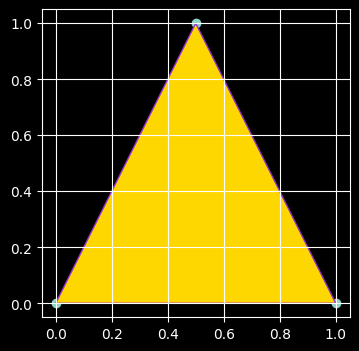

In [55]:
x_prueba = np.array([0,1,0.5])
y_prueba = np.array([0,0,1])

polygon_prueba = np.array([x_prueba, y_prueba])

plt.figure(figsize=(6,4))
plt.scatter(x_prueba, y_prueba); plt.fill(x_prueba, y_prueba, edgecolor="darkorchid", facecolor="gold");
plt.grid(); plt.axis("scaled")        # or plt.axis("equal")

In [56]:
def area_voronoi(Polygons, index=None):
    if index == None:
        n_regions = len(Polygons)
        X, Y, n_area, S = [], [], [], np.zeros(n_regions)
        for i in range(n_regions):
            X.append(Polygons[i][0])
            Y.append(Polygons[i][1])
            n_area = len(X[i])
            for k in range(n_area):
                S[i] += X[i][k]*Y[i][(k+1) % n_area] - X[i][(k+1) % n_area]*Y[i][k]
    else:
        n_area = Polygons[index].shape[1]
        X, Y = Polygons[index]
        S = 0
        for i in range(n_area):
            S += X[i]*Y[(i+1) % n_area] - X[(i+1) % n_area]*Y[i]

    return (1/2)*np.abs(S)

(-1.9277930279070328,
 1.9277930279070328,
 -1.7853631357004125,
 1.8694284514291222)

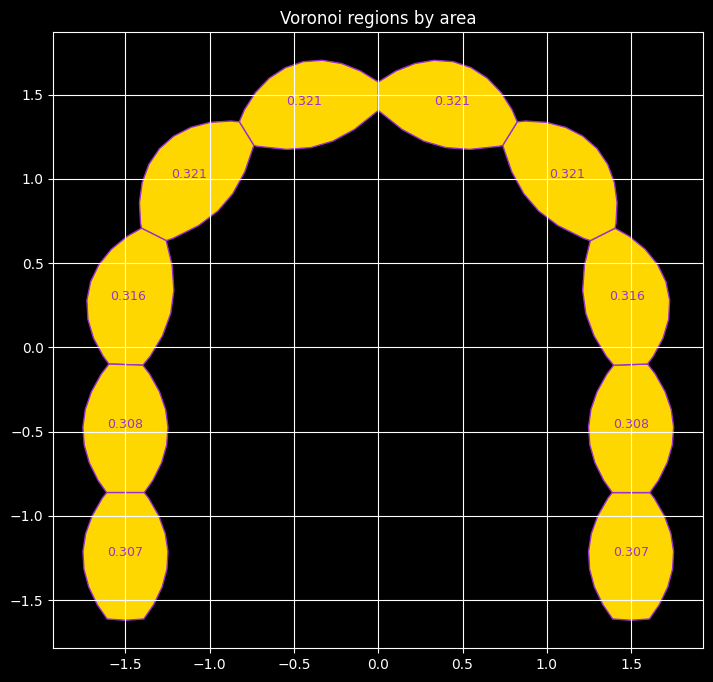

In [57]:
A_vor = area_voronoi(Polygons)

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(A_vor[i], 3)
    plt.text(np.mean(X), np.mean(Y), f'${num_label}$', fontsize=9, horizontalalignment='center',
             color='darkorchid', fontweight='bold')
    plt.fill(X, Y, edgecolor="darkorchid", facecolor="gold")
plt.title("Voronoi regions by area");
plt.grid(); plt.axis("scaled")        # or plt.axis("equal")

---

Ahora se calcula el centroide de cada polígono

In [58]:
def centroid_voronoi(Polygons, index=None):
    if index == None:
        n_regions = len(Polygons)
        X, Y, CX, CY = [], [], np.zeros(n_regions), np.zeros(n_regions)

        for i in range(n_regions):
            X.append(Polygons[i][0])
            Y.append(Polygons[i][1])
            n_centroid = len(X[i])
            for k in range(n_centroid):
                CX[i] += (X[i][k] + X[i][(k+1) % n_centroid]) * (X[i][k] * Y[i][(k+1) % n_centroid] - X[i][(k+1) % n_centroid]*Y[i][k])
                CY[i] += (Y[i][k] + Y[i][(k+1) % n_centroid]) * (X[i][k] * Y[i][(k+1) % n_centroid] - X[i][(k+1) % n_centroid]*Y[i][k])
        A = area_voronoi(Polygons)
        cX = CX / (6*A)
        cY = CY / (6*A)
        for j in range(n_regions):
            if abs(cX[j] - np.mean(X[j]))  > abs(-cX[j] - np.mean(X[j])):
                cX[j] = -cX[j]
            if abs(cY[j] - np.mean(Y[j]))  > abs(-cY[j] - np.mean(Y[j])):
                cY[j] = -cY[j]

    else:
        n_centroid = Polygons[index].shape[1]
        X, Y = Polygons[index]
        A = area_voronoi(Polygons, index=index)
        CX, CY = np.empty([2, n_centroid])

        for i in range(n_centroid):
            CX[i] = (X[i] + X[(i+1) % n_centroid]) * (X[i] * Y[(i+1) % n_centroid] - X[(i+1) % n_centroid]*Y[i])
            CY[i] = (Y[i] + Y[(i+1) % n_centroid]) * (X[i] * Y[(i+1) % n_centroid] - X[(i+1) % n_centroid]*Y[i])

        cX, cY = (np.sum(CX), np.sum(CY))/(6*A)
        if abs(cX - np.mean(X)) > abs(-cX - np.mean(X)):
            cX = -cX
        if abs(cY - np.mean(Y)) > abs(-cY - np.mean(Y)):
            cY = -cY
    return np.array([cX, cY])

(-2.2, 2.2, -2.1999486216200688, 2.1989210540214446)

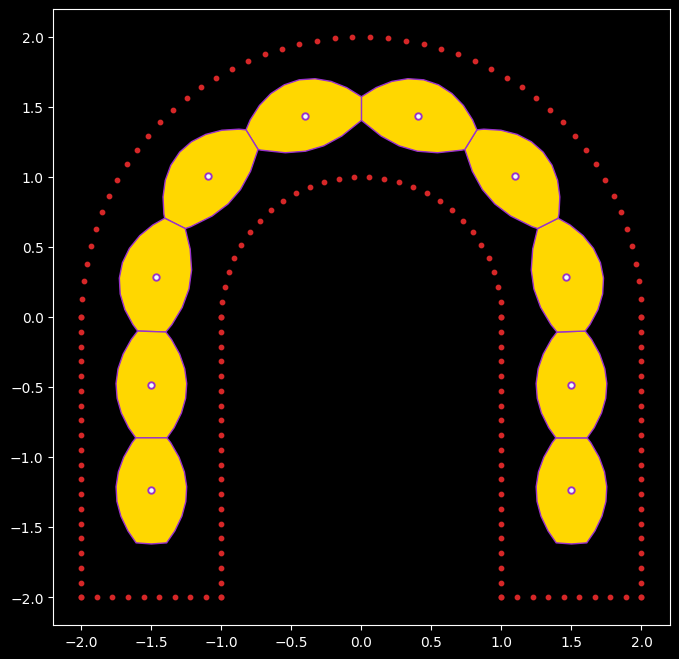

In [59]:
C_vor = centroid_voronoi(Polygons);
fig, ax = plt.subplots();

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(area_voronoi(Polygons, index=i), 3)
    # plt.text(C_vor[0][i], C_vor[1][i]+0.035, f'${i}$', fontsize=8, horizontalalignment='center', color='black', fontweight='bold')
    ax.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")
ax.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=1, s=25)
ax.scatter(C_vor[0], C_vor[1], color="azure", zorder=2, s=5)
# plt.title("Voronoi regions with centroids");
plt.scatter(structure[0], structure[1], color="tab:red", s=10)
plt.axis("scaled")        # or plt.axis("equal")

(-1.9277930279070328,
 1.9277930279070328,
 -1.7853631357004125,
 1.8694284514291222)

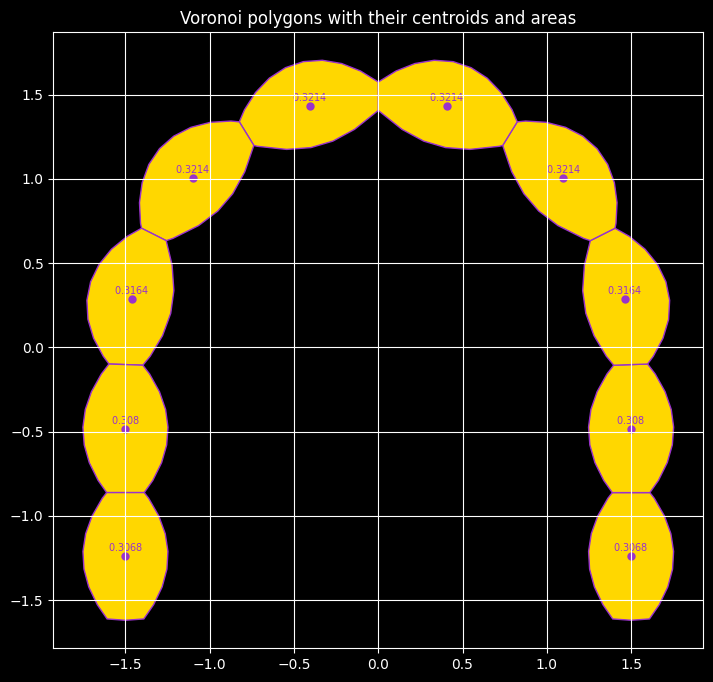

In [60]:
A_vor = area_voronoi(Polygons);
C_vor = centroid_voronoi(Polygons);

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(A_vor[i], 4)
    plt.text(C_vor[0][i], C_vor[1][i]+0.029, f'${num_label}$', fontsize=7, horizontalalignment='center',
             color='darkorchid', fontweight='bold', zorder=1)
    plt.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")
plt.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=-1, s=25); ax.scatter(C_vor[0], C_vor[1], color="azure", zorder=0, s=5)
plt.title("Voronoi polygons with their centroids and areas")
plt.grid(); plt.axis("scaled")        # or plt.axis("equal")

*   ###  __Paso $N+3$:__ _Definiendo las interacciones y evolución del sistema a partir del potencial $V(\vec{x},t)$_

\begin{align}
    V(\vec{r_i}, t) = \frac{K_v}{2}\left(A_i(t)-A_0(t)\right)^2 + \frac{K_c}{2}\big|\vec{r}_i(t) - \vec{r}_{0,i}(t)\big|^2
\end{align}

donde $A_0 = \sum_{i=1}^N(A_i/N)$

[Cell Patterns Emerge from Coupled Chemical and Physical Fields with Cell Proliferation Dynamics: The Arabidopsis thaliana Root as a Study System](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3642054/)

In [61]:
def dist_vor(vor_points, C_vor, index=None):
    if index==None:
        cX, cY = C_vor
        X, Y = vor_points[:C_vor.shape[1]].T
        dist = (X - cX)**2 + (Y - cY)**2
    else:
        cX, cY = C_vor.T[index]
        X, Y = vor_points[index]
        dist = (X - cX)**2 + (Y - cY)**2
    return dist

(-2.2, 2.2, -2.1999486216200688, 2.1989210540214446)

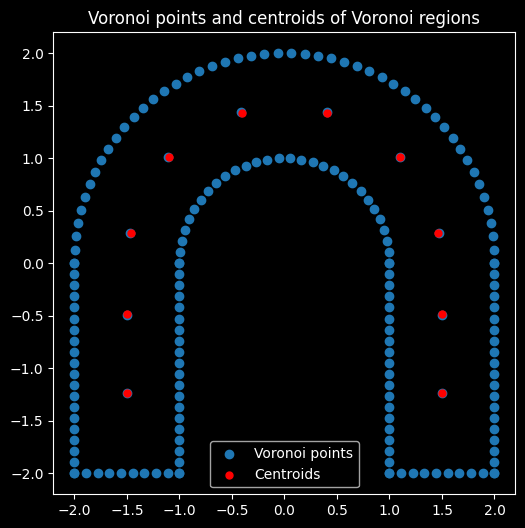

In [62]:
plt.figure(figsize=(10,6))
plt.scatter(vor.points.T[0], vor.points.T[1], color="tab:blue", label="Voronoi points")
plt.scatter(C_vor[0], C_vor[1], color="red", s=25, label="Centroids")
plt.title("Voronoi points and centroids of Voronoi regions");
plt.legend(); plt.axis("scaled")        # or plt.axis("equal")

In [63]:
K = [0.5, 0.5, 0.5]
A_0 = (np.pi/2)*(r[1]**2 - r[0]**2)/len(Polygons)

def potential_vor(K, vor_points, A_vor, C_vor, A_mean=None):
    if A_mean == None:
        A_mean = np.mean(A_vor)
    v1 = K[0]/2 * (A_vor - A_mean)**2
    v2 = K[1]/2 * dist_vor(vor_points, C_vor)
    return v1 + v2

(-1.9277930279070328,
 1.9277930279070328,
 -1.7853631357004125,
 1.8694284514291222)

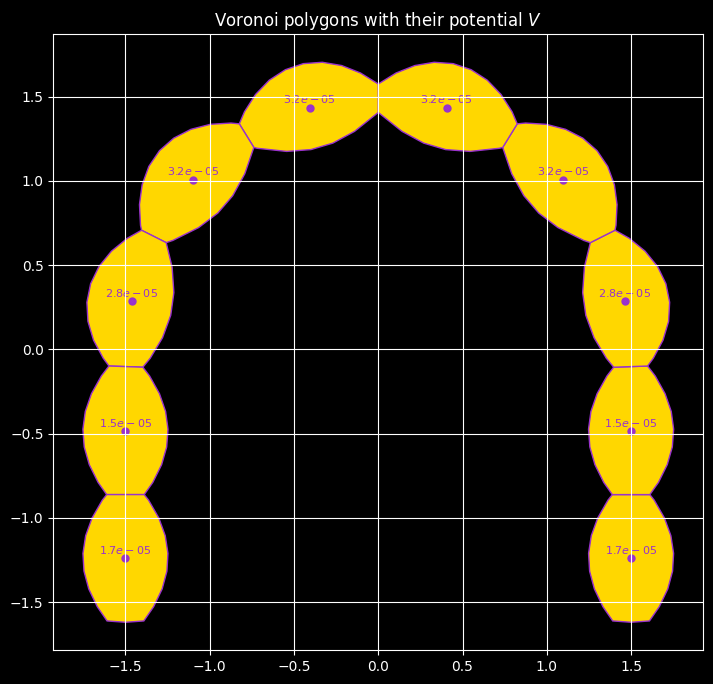

In [64]:
V_vor = potential_vor(K, vor.points, A_vor, C_vor)

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(V_vor[i], 6)
    plt.text(C_vor[0,i], C_vor[1,i]+0.025, f'${num_label}$', fontsize=np.sqrt(V_vor[i])+8,
             horizontalalignment='center', color='darkorchid', fontweight='bold', zorder=1)
    plt.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")
    plt.scatter(C_vor[0,i], C_vor[1,i], color="azure", zorder=0, s=V_vor[i]*10)

plt.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=-1, s=25);
plt.title("Voronoi polygons with their potential $V$")
plt.grid(); plt.axis("scaled")        # or plt.axis("equal")

\begin{align}
    F_x(x_i, t) = &-\frac{K_v}{2}\left[\frac{1}{2}\sum_{m=1}^{M} \frac{(x_i-x_m)\cdot l_{i,m}}{|\vec{r}_i-\vec{r}_m|}\{A_i - A_0\}\right]\\
                  &- K_c(x_i-x_{0,i})\\
    F_y(y_i, t) = &-\frac{K_v}{2}\left[\frac{1}{2}\sum_{m=1}^{M} \frac{(y_i-y_m)\cdot l_{i,m}}{|\vec{r}_i-\vec{r}_m|}\{A_i - A_0\}\right]\\
                  &- K_c(y_i-y_{0,i})
\end{align}

In [65]:
def get_lines(vor, N_points):
    line_segments, line_regions, vor_surface = [], [], []
    for simplex, pointidx in zip(vor.ridge_vertices, vor.ridge_points):
        if -1 not in simplex:
            pointidx = np.asarray(pointidx)
            simplex = np.asarray(simplex)
            if np.any(pointidx <= N_points - 1):
                if np.any(pointidx > N_points - 1):
                    a, _ = np.sort(pointidx)
                    vor_surface.append(a)
                else:
                    line_segments.append(vor.vertices[simplex])
                    line_regions.append(pointidx)

    line_segments = np.array(line_segments)
    line_regions = np.array(line_regions)
    vor_surface = np.array(list(set(vor_surface)))
    return line_segments, line_regions, vor_surface

(-1.9277930279070328,
 1.9277930279070328,
 -1.7853631357004125,
 1.8694284514291222)

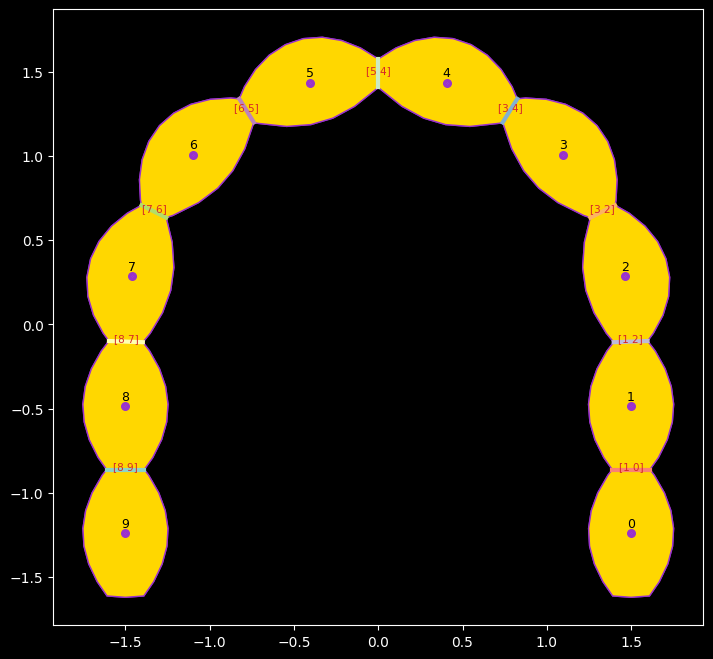

In [66]:
line_segments, line_regions, vor_surface = get_lines(vor, N)
plt.figure(figsize=(12,8), dpi=100)

for i in range(len(line_segments)):                                 # Plot shared lines
    line_segment = line_segments[i]
    x_line = line_segment[:,0]
    y_line = line_segment[:,1]
    plt.plot(x_line, y_line, linewidth=3)
    plt.text(np.mean(x_line), np.mean(y_line), f"{line_regions[i]}", color="tab:red", zorder=2, fontsize=7.5, horizontalalignment='center')

for i in range(len(Polygons)):                                      # Visualize Voronoi regions
    X, Y = Polygons[i]
    plt.fill(X, Y, zorder=-3, edgecolor="darkorchid", facecolor="lightgreen")
    plt.text(C_vor[0][i], C_vor[1][i] + 0.035, f"{i}", color="black", zorder=0, fontsize=9, horizontalalignment='center')
    plt.scatter(C_vor[0][i], C_vor[1][i], color="azure", zorder=0, s=V_vor[i]*50)

for i in vor_surface:                                              # Plot shared lines
    X, Y = Polygons[i]
    plt.fill(X, Y, zorder=-3, edgecolor="darkorchid", facecolor="gold")

plt.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=-1, s=30);
# plt.grid();
plt.axis("scaled")        # or plt.axis("equal")

In [67]:
def get_dist_dict(vor, N_points):
    dist_dict = {}
    line_segments, line_regions, vor_surface = get_lines(vor, N_points)
    for k in range(len(line_regions)):
        i, m = sorted(line_regions[k])
        d = np.sum((line_segments[k][0] - line_segments[k][1])**2)
        dist_dict[(i,m)] = d
    return dist_dict, vor_surface

dist_dict, vor_surface = get_dist_dict(vor, N)

<ipython-input-68-d06f867921aa>:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


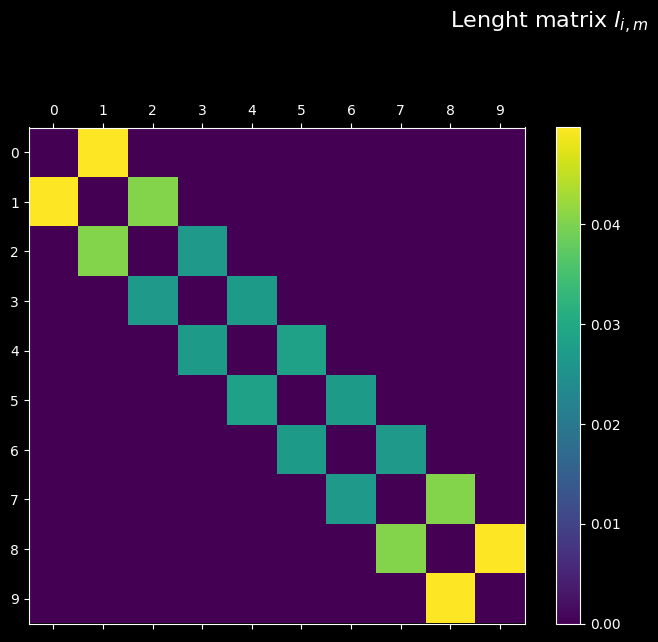

In [68]:
s = (N, N)
empty_matrix = np.zeros(s)
for k in range(len(line_regions)):
    i, m = sorted(line_regions[k])
    d = np.sum((line_segments[k][0] - line_segments[k][1])**2)
    empty_matrix[i,m] += d
    empty_matrix[m,i] += d

plt.matshow(empty_matrix);
plt.xlim([-0.5, N - 0.5]); plt.ylim([N - 0.5, -0.5]);
plt.xticks([i for i in range(N)])
plt.yticks([i for i in range(N)])
# plt.title("Lenght matrix $l_{i,m}$");
plt.text(10, -2.5, "Lenght matrix $l_{i,m}$", color="white", zorder=0, fontsize=16, horizontalalignment='center')
# plt.colorbar(empty_matrix);
im = plt.imshow(empty_matrix)
plt.colorbar(im, shrink=0.8)
plt.tight_layout()
# plt.grid()

In [69]:
def F(K, X_pts, A_vor, C_vor, dist_dict, i, A_mean=None):
    f, l = np.zeros(2), np.zeros(2)
    if A_mean == None:
        A_mean = np.mean(A_vor)
    area_diff = A_vor - np.mean(A_vor)
    dist_diff = X_pts[i] - C_vor.T[i]
    for key in dist_dict.keys():
        a, b = key
        if (a == i) or (b == i):
            if a == i: pass
            else: b = a
            r_temp = X_pts[i] - X_pts[b]
            l += (dist_dict[key] * r_temp * area_diff[i]) / (np.linalg.norm(r_temp))      # evolución dinámica
    f = -(K[0] * l)/4 - (K[1] * dist_diff)
    return f

In [70]:
def gates(i, b, dist_dict, vor_surface, C_vor):
    value = False;
    i, b = sorted((i, b))
    v1 = (i in vor_surface)
    v2 = (b in vor_surface)
    if (i, b) in dist_dict.keys():
        # v3 = (C_vor[0][i] > C_vor[0][b])      # x_i above x_b
        v3 = (C_vor[0][i] < C_vor[0][b])      # x_i below x_b
        s1 = (v1 and v2 and v3)
        s3 = (not v1) and v2 and v3
        value = s1 or s3
    else:
        value = not (v1 or v2)
    return value

gates(0, 15, dist_dict, vor_surface, C_vor)

False

In [71]:
C, alpha = np.random.rand(N), 0.1

def C_field(K, vor_points, A_vor, C_vor, dist_dict, vor_surface, i, C0, alpha, A_mean=None, state=True):
    dC = 0
    V_field = potential_vor(K, vor_points, A_vor, C_vor, A_mean=A_mean)
    for key in dist_dict.keys():
        a, b = key
        if (a == i) or (b == i):
            if a == i: pass
            else: b = a
            if state == True:
                if gates(i, b, dist_dict, vor_surface, C_vor):
                    c_diff = C0[i] - C0[b]
                    v_diff = abs(V_field[i] - V_field[b])
                    dC += dist_dict[key] * c_diff * v_diff
            else:
                c_diff = C0[i] - C0[b]
                v_diff = abs(V_field[i] - V_field[b])
                dC += dist_dict[key] * c_diff * v_diff
    dC = alpha * dC
    return dC

C_field(K, vor.points, A_vor, C_vor, dist_dict, vor_surface, 4, C, alpha, state=True)

0.0

<ipython-input-72-f0a733d666fc>:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


(<Figure size 800x640 with 2 Axes>, <Axes: >)

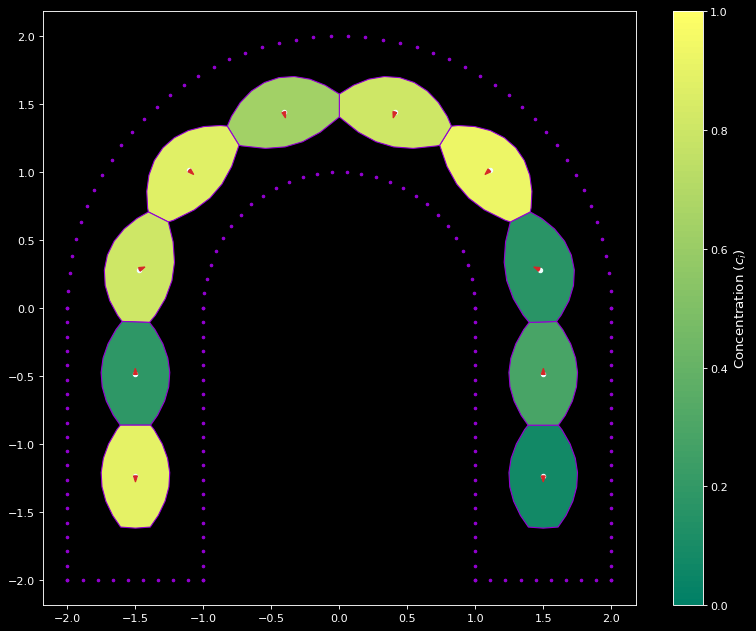

In [72]:
def voronoi_forces(K, vor, A_vor, C_vor, N_points, C0, C_cells, alpha, V=None, state=True):
    fig, ax = plt.subplots(figsize=(10,8), dpi=80)
    Polygons = get_polygons(vor, N_points)
    dist_dict, vor_surface = get_dist_dict(vor, N_points)

    points = vor.points[:N_points]
    pts_structure = vor.points[N_points:].T
    A_mean = np.mean(A_vor)

    for i in range(N_points):
        X, Y = Polygons[i]
        Fx, Fy = F(K, points, A_vor, C_vor, dist_dict, i, A_mean=A_mean)
        dC = C_field(K, points, A_vor, C_vor, dist_dict, vor_surface, i, C0, alpha, A_mean=A_mean, state=state)
        ax.arrow(points[i][0], points[i][1], Fx, Fy, width = 0.01, color="tab:red")
        if V is not None:
            ax.arrow(points[i][0], points[i][1], V[0][i], V[1][i], width = 0.001, color="tab:blue")
        if not C_cells[i]: ax.fill(X, Y, zorder=-2, edgecolor="darkviolet", facecolor=mycolor(C0[i]))   # rojo = C_alto
        else: ax.fill(X, Y, zorder=-2, edgecolor="darkviolet", facecolor="orange")   # rojo = C_alto
    ax.scatter(points.T[0], points.T[1], color="azure", zorder=-1, s=15);
    ax.scatter(pts_structure[0], pts_structure[1], color="darkviolet", zorder=0, s=5)

    sm = plt.cm.ScalarMappable(cmap=mycolor)
    cbar = plt.colorbar(sm)
    # plt.text(2.95, 0, "Concentración $(c_i)$", color="white", zorder=0, fontsize=16, va='center', rotation=90)
    cbar.set_label('Concentration $(c_i)$', rotation=90, fontsize=12)
    plt.axis("equal")        # or plt.axis("equal")
    plt.tight_layout()
    return fig, ax

C_cells = np.zeros(N);
voronoi_forces([1.9,0.2,0.4], vor, A_vor, C_vor, N, C, C_cells, alpha, V=None, state=False)

## Evolución del sistema (con transporte de auxinas y división celular)

Suponemos que la concentración de auxinas mantiene un comportamiento periódico en cada célula, por lo que decimos que el periodo del sistema para un cíclo auxinar es el siguiente al considerar una dinámica depredador-presa.

$$ T_0= 2\pi(1.95)\ [u_t] = 12.25\ [u_t]$$

Y como $T_0=\frac{2\pi}{\sqrt{\beta_0}}=2\pi(1.95)\ [u_t]$, al resolver para la variable $\beta_0$ se obtiene $\beta_0=0.262985$.

Por otra parte, si consideramos que el periodo de cada célula varía ligeramente del periodo del sistema en función de la concentración de auxinas

$$ T_i = \frac{2\pi}{\sqrt{\beta_0}}\left[1+ \frac{\gamma}{2}(c_i - \langle c_i \rangle)\right], $$

de tal modo que $\langle T_i \rangle = T_0$, por lo que mantiene el comportamiento del sistema completo.

En este caso, el cambio del periodo individual de las células $\frac{d T_i}{dt}$ está dado por la siguiente ecuación.

$$ \frac{d T_i}{dt} = \frac{\gamma\ T_0}{2} \left[ \frac{dc_i}{dt} - \frac{d\langle c_i \rangle}{dt} \right] $$

Y finalmente, si consideramos un sistema metaestáble podemos suponer que el término del promedio es casi nulo, $\frac{d\langle c_i\rangle}{dt} \approx 0$, por lo que nuestro cambio en el periodo es el siguiente.

$$ \frac{d T_i}{dt} = \frac{\gamma\ T_0}{2} \left(\frac{dc_i}{dt} - \left\langle\frac{dc_i}{dt}\right\rangle \right), \qquad T_0 = \frac{2 \pi}{\sqrt{\beta_0}} $$

In [73]:
def timer_celldiv(dC, C0, T0, C_cells, beta, gamma, c_factor=1.0):
    dT = (np.pi*gamma)*(beta)**(-1/2) * (dC - np.mean(dC))
    return dT * (1 + C_cells*c_factor)
    # return 0

\begin{align}
    \frac{d\vec{r}}{dt} &= \vec{v} \\
    \frac{d\vec{v}}{dt} &= \vec{F}_T = -\nabla V - k\vec{v}\\
    \frac{1}{\alpha}\frac{dc_i}{dt} &= \sum_{m=1}^{M} l_{i,m}(c_i-c_m) |V_i-V_m| \\
    \frac{dT}{dt} &= \frac{\gamma\ T_0}{2} \left(\frac{dc_i}{dt} - \left\langle\frac{dc_i}{dt}\right\rangle \right)\qquad\ \text{(Cambio del periodo de las células)}
\end{align}

In [74]:
def dX(K, A_vor, C_vor, dist_dict, vor_surface, X0, C0, T0, C_cells, alpha, beta, gamma, A_mean=None, state=True):
    X_pts, V_pts = X0[:,0:2], X0[:,2:4]
    N_points = len(T0)

    if A_mean == None:
        A_mean = np.median(A_vor)

    dX_ = V_pts                                  # (dx, dy) = (Vx, Vy)
    dV_ = np.zeros(V_pts.shape)                  # (dVx, dVy) = (Fx, Fy)
    dC_ = np.zeros(C0.shape)                     # 1/1alpha * dC[i]
    dT_ = np.zeros(T0.shape)

    for i in range(N_points):
        dV_[i] = F(K, X_pts, A_vor, C_vor, dist_dict, i, A_mean=A_mean) - K[2]*dX_[i]
        dC_[i] = C_field(K, X_pts, A_vor, C_vor, dist_dict, vor_surface, i, C0, alpha, A_mean=A_mean, state=state)
    dT_ = timer_celldiv(dC_, C0, T0, C_cells, beta, gamma)
    dX = np.concatenate([dX_, dV_], axis=1)

    return dX, dC_, dT_

### Proceso de división celular

Primero definimos el proceso de división individual para pasar de una célula a dos células. Se siguen los siguientes pasos:

1. Se avanza el reloj interno $\frac{dT_i}{d\tau}$ de cada célula según la variable $\tau$ del sistema biológico. (Es necesario iniciar previamente $T_i$)
2. Detectar cuales células cumplan el cíclo y resetear su reloj $T_i=0$ después de
3. En cada una de estas células, agregar un nuevo punto $\vec{r}_j=\vec{r}_i + \vec{r_c}(A_i)$, donde $|r_c|$ suele ser $1/4$ el radio de la célula $i$.

In [75]:
def cell_cycle(A_vor, C_vor, X0, C0, T0, C_cells, N_div, N_points, structure, scale=1/3, celldiv=True, l_step=5, limits = (-0.1, 0.1)):
    if celldiv == True:
        T_temp = (1.95)*2*np.pi
        if N_div == l_step//2 :
            tmp = (2*T0 - T_temp) / T_temp
            if np.any(tmp >= limits[1]) == True:
                print("Cell division! ", np.sum(tmp >= limits[1]))
                for i in range(N_points):
                    if (tmp[i] >= limits[1]) * (not C_cells[i]):
                        A_vor, C_vor, (X0, C0, T0, C_cells) = new_division(A_vor, X0, C0, T0, C_cells, i, structure, scale=scale)

        if N_div == l_step :
            N_div = 0
            tmp = (T0 - T_temp) / T_temp
            b_tmp1 = (tmp >= limits[1]) * (C_cells)
            if np.any(b_tmp1) == True:
                print("Cancer cell! ", np.sum(b_tmp1, dtype=int))
                for i in range(N_points):
                    if b_tmp1[i]:
                        A_vor, C_vor, (X0, C0, T0, C_cells) = new_division(A_vor, X0, C0, T0, C_cells, i, structure, scale=scale)
            tmp = (T0 - T_temp) / T_temp
            b_tmp2 = (tmp <= limits[0]) * (1 - C_cells)
            if np.any(b_tmp2) == True:
                print("Cell death! ",  np.sum(b_tmp2, dtype=int))
                indices = []
                for i in range(N_points):
                    if b_tmp2[i]:
                        indices.append(i)
                A_vor, C_vor, (X0, C0, T0, C_cells) = cell_death(X0, C0, T0, C_cells, indices, structure)
        N_div += 1
    else:
        N_div = 0

    N_points = len(T0)
    vor = mk_voronoi(X0[:,0:2], structure)
    Polygons = get_polygons(vor, N_points)

    S = [A_vor, C_vor, X0, C0, T0, C_cells]
    return S, N_points, vor, Polygons, N_div

In [76]:
def new_division(A_vor, X0, C0, T0, C_cells, i, structure, scale=1/4):
    X_pts, V_pts = X0[:,0:2], X0[:,2:4]
    X, V = X_pts[i], V_pts[i]
    r, E, arr = (A_vor[i]/np.pi)**(1/2), np.sum((V**2)/2), np.random.rand(2)
    hat = arr / np.linalg.norm(arr)
    # -----------------------------------------
    dX = r * scale * hat / 2
    X_pts[i] = X - dX
    X_pts = np.append(X_pts, [X + dX], axis=0)              # se agrega un nuevo punto

    dV = (0.866025) * np.linalg.norm(V) * hat    # sqrt(3)/2
    V_pts[i] = V/2 - dV
    V_pts = np.append(V_pts, [V/2 + dV], axis=0)            # se reparte la energía cinética entre las 2 células

    X0 = np.concatenate([X_pts, V_pts], axis=1)             # se guarda todo en X0
    # -----------------------------------------
    C0[i] /= 2
    C0 = np.append(C0, [C0[i]], axis=0)                     # se reparte la concentración de auxinas entre 2
    # -----------------------------------------
    T0 = np.append(T0, [T0[i]], axis=0)                     # se copia la informacion de los relojes internos
    # -----------------------------------------
    C_cells = np.append(C_cells, [C_cells[i]], axis=0)      # se hereda la información del estado de la célula
    # -----------------------------------------
    vor = mk_voronoi(X0[:,0:2], structure)
    N_points = len(X0)
    Polygons = get_polygons(vor, N_points)
    A_vor = area_voronoi(Polygons)
    C_vor = centroid_voronoi(Polygons);

    return A_vor, C_vor, (X0, C0, T0, C_cells)

# new_division(np.copy(vor.points[:N]), np.copy(A_vor), 0)[0][-1], new_division(np.copy(vor.points[:N]), np.copy(A_vor), 0)[1][-1]

In [77]:
def cell_death(X0, C0, T0, C_cells, indices, structure):
    indices = indices
    X_pts, V_pts = X0[:,0:2], X0[:,2:4]
    # -----------------------------------------
    X_pts = np.delete(X_pts, indices, axis=0)                     # se elimina la posición del punto "i"
    V_pts = np.delete(V_pts, indices, axis=0)                     # se elimina la velocidad del punto "i"

    X0 = np.concatenate([X_pts, V_pts], axis=1)             # se guarda todo en X0
    # -----------------------------------------
    C0 = np.delete(C0, indices, axis=0)                           # se elimina la concentración de auxinas del punto "i"
    # -----------------------------------------
    T0 = np.delete(T0, indices, axis=0)                           # se borra el reloj del punto "i"
    # -----------------------------------------
    C_cells = np.delete(C_cells, indices, axis=0)                      # se borra el reloj del punto "i"
    # -----------------------------------------
    vor = mk_voronoi(X0[:,0:2], structure)
    N_points = len(X0)
    Polygons = get_polygons(vor, N_points)
    A_vor = area_voronoi(Polygons)
    C_vor = centroid_voronoi(Polygons);

    return A_vor, C_vor, (X0, C0, T0, C_cells)

# new_division(np.copy(vor.points[:N]), np.copy(A_vor), 0)[0][-1], new_division(np.copy(vor.points[:N]), np.copy(A_vor), 0)[1][-1]

-------

## Finalmente, evolucionamos el sistema biológico...

In [78]:
def RK_solver(K, lenght, vor, X0, C0, T0, C_cells, params, t, N_points, structure,
              A_fixed=None, N_div=None, scale=1/4, state=True, celldiv=True, l_step=5, limits=(-0.1, 0.1)):
    alpha, beta, gamma = params
    Polygons = get_polygons(vor, N_points)
    A_vor, C_vor = area_voronoi(Polygons), centroid_voronoi(Polygons);
    dist_dict, surface = get_dist_dict(vor, N_points)

    if A_fixed == None:
        A_fixed = np.median(A_vor)
    if N_div == None:
        N_div = 0
    dt = t[1] - t[0];

    for i in range(len(t)):
        rX = np.empty([4, X0.shape[0], X0.shape[1]])
        rC = np.empty([4, C0.shape[0]])
        rT = np.empty([4, T0.shape[0]])

        rX[0],rC[0],rT[0] = dX(K, A_vor, C_vor, dist_dict, surface, X0             , C0             , T0             , C_cells, alpha, beta, gamma, A_mean=A_fixed, state=state)
        rX[1],rC[1],rT[1] = dX(K, A_vor, C_vor, dist_dict, surface, X0 + dt*rX[0]/2, C0 + dt*rC[0]/2, T0 + dt*rT[0]/2, C_cells, alpha, beta, gamma, A_mean=A_fixed, state=state)
        rX[2],rC[2],rT[2] = dX(K, A_vor, C_vor, dist_dict, surface, X0 + dt*rX[1]/2, C0 + dt*rC[1]/2, T0 + dt*rT[1]/2, C_cells, alpha, beta, gamma, A_mean=A_fixed, state=state)
        rX[3],rC[3],rT[3] = dX(K, A_vor, C_vor, dist_dict, surface, X0 + dt*rX[2]  , C0 + dt*rC[2]  , T0 + dt*rT[2]/2, C_cells, alpha, beta, gamma, A_mean=A_fixed, state=state)

        ss_X = rX[0] + 2*rX[1] + 2*rX[2] + rX[3]
        ss_C = rC[0] + 2*rC[1] + 2*rC[2] + rC[3]
        ss_T = rT[0] + 2*rT[1] + 2*rT[2] + rT[3]
        X0 += dt*ss_X/6
        C0 += dt*ss_C/6
        T0 += dt*ss_T/6

    S, N_points, vor_out, Polygons, N_div = cell_cycle(A_vor, C_vor, X0, C0, T0 + lenght, C_cells, N_div, N_points, structure,
                                                       scale=scale, celldiv=celldiv, l_step=l_step, limits=limits)
    # A_vor, C_vor, X0, C0, T0, C_cells = S

    dist_dict, surface = get_dist_dict(vor_out, N_points)
    A_fixed = np.mean(area_voronoi(Polygons))
    # C0 = C0 / np.max(C0)
    return S, (vor_out, Polygons, dist_dict, surface), N_points, N_div

def euler_solver(K, lenght, vor, X0, C0, T0, C_cells, params, t, N_points, structure,
                 A_fixed=None, N_div=None, scale=1/4, state=True, celldiv=True, l_step=5, limits=(-0.1, 0.1)):
    alpha, beta, gamma = params
    Polygons = get_polygons(vor, N_points)
    A_vor, C_vor = area_voronoi(Polygons), centroid_voronoi(Polygons);
    dist_dict, surface = get_dist_dict(vor, N_points)

    if A_fixed == None:
        A_fixed = np.median(area_voronoi(Polygons))
    if N_div == None:
        N_div = 0
    dt = t[1] - t[0];

    for i in range(len(t)):
        temp = dX(K, A_vor, C_vor, dist_dict, surface, X0, C0, T0, C_cells, alpha, beta, A_mean=A_fixed, state=state)
        X0, C0, T0 = X0 + dt*temp[0], C0 + dt*temp[1], T0 + dt*temp[2]

    S, N_points, vor_out, Polygons, N_div = cell_cycle(A_vor, C_vor, X0, C0, T0 + lenght, C_cells, N_div, N_points, structure,
                                                       scale=scale, celldiv=celldiv, l_step=l_step, limits=limits)
    # A_vor, C_vor, X0, C0, T0, C_cells = S

    dist_dict, surface = get_dist_dict(vor_out, N_points)
    A_fixed = np.mean(area_voronoi(Polygons))
    # C0 = C0 / np.max(C0)
    return S, (vor_out, Polygons, dist_dict, surface), N_points, N_div

In [79]:
def evolve_vornonoi(r, theta, l, K, vor, C0, C_cells, N, params,
                    step=0.1, lenght=100, iter=20, vel=0.01, method="RK4", A_fixed=None,
                    scale=1/4, filenames=None, C_list=None, state=True, celldiv=True, l_evol=True, l_step=5, limits=(-0.1, 0.1)):
    """
    solver["RK4"]: Runge-Kutta order 4
    solver["Euler"]: Euler method
    """
    T0 = np.zeros(N)
    dl = [0,0]

    N_div = 1
    if filenames == None:
        filenames = []

    if C_list == None:
        C_list = []

    points, structure = vor.points[:N], vor.points[N:].T
    solver = {"RK4":RK_solver, "Euler":euler_solver}[method]

    t = np.arange(0, lenght/l_step, step)
    X0 = np.concatenate([points, np.random.normal(0, vel, points.shape)], axis=1)       # mov. browniano inicial
    X_out, V_out = X0[:,0:2], X0[:,2:4]

    Polygons = get_polygons(vor, N)
    dist_dict = get_dist_dict(vor, N)

    A_vor = area_voronoi(Polygons);
    C_vor = centroid_voronoi(Polygons);
    tmp_A = np.std(A_vor)
    C_list.append(C0)

    print("evolve_voronoi: ", N_div, ",\t C_cells: ",np.sum(C_cells, dtype=int), ",\t A_mean: ",np.mean(A_vor), ",\t A_mean: ",np.mean(A_vor))
    print("\tT0:", np.min(T0), np.mean(T0), np.max(T0))
    print("\tC0:", round(np.min(C0),4),"\t", round(np.mean(C0),4),"\t", round(np.std(C0),4),"\t", round(np.max(C0),4))
    print("\tdl:", round(dl[0],4),"\t", round(dl[1],4),",\t A_geo:", A_total(r, l, N, cols=1))

    fig, ax = voronoi_forces(K, vor, A_vor, C_vor, N, C0, C_cells, alpha, V=V_out.T)
    ax.set_title(f"Graph: {0},   t={0} days,   $N=${N},   method: {method},   $A_T/A_g=${round(np.sum(A_vor)/A_total(r, l, N, cols=1), 3)},   $l=${l}")           # t_real = t/0.3016241
    plt.show()

    filename = f'/content/drive/MyDrive/biomath_model/figures/prueba0.png'
    filenames.append(filename)
    fig.savefig(filename, bbox_inches='tight')

    for i in range(iter):
        S1, S2, N, N_div = solver(K, lenght/l_step, vor, X0, C0, T0, C_cells, params, t, N, structure, A_fixed=A_fixed,
                                         N_div=N_div, scale=scale, state=state, celldiv=celldiv, l_step=l_step, limits=limits)
        A_vor, C_vor, X0, C0, T0, C_cells = S1
        vor, Polygons, dist_dict, surface = S2
        X_out, V_out = X0[:,0:2], X0[:,2:4]
        C0 /= np.max(C0)

        # Actualización de la longitud # -------------------------------------------------------
        if l_evol == True:
            if (i+1) % l_step == 0:
                T0 *= 0
            else: pass

            if dl[1] > 0:
                l += dl[0] / l_step
                structure = get_structure(r, theta, l, 100)
                vor = mk_voronoi(X0[:,0:2], structure)
                dl[1] -= 1
            else: pass

            if dl[1] == 0:
                dl = [0, l_step]
                if np.sum(A_vor) > 0.94*A_total(r, l, N, cols=1):
                    dl[0] += np.sum(A_vor)/(r[1]-r[0]) * (N + 1)/(N**2)
                else:
                    dl[0] = 0

                if np.sum(A_vor) > 0.85*A_total(r, l, N, cols=1):
                    if (np.std(A_vor) - tmp_A)/tmp_A > 0.05:
                        dl[0] += (np.std(A_vor) - tmp_A)
                    else: pass
                    if (np.std(A_vor) - tmp_A)/tmp_A < - 0.05:
                        dl[0] += 0.5*(np.std(A_vor) - tmp_A)
                    else: pass
                else: pass

                tmp_A = np.std(A_vor)
        # ---------------------------- # -------------------------------------------------------

        print("evolve_voronoi: ", N_div, ",\t C_cells: ",np.sum(C_cells, dtype=int), ",\t A_mean: ",round(np.mean(A_vor),5), ",\t A_std: ",round(np.std(A_vor),5), "Graph: ",i+1)
        print("\tT0:", round(np.min(T0)/(1.98*2*np.pi),4),"\t", round(np.mean(T0)/(1.98*2*np.pi),4),"\t", round(np.max(T0)/(1.98*2*np.pi),4))
        print("\tC0:", round(np.min(C0),4),"\t", round(np.mean(C0),4),"\t", round(np.std(C0),4),"\t", round(np.max(C0),4))
        print("\tdl:", round(dl[0],4),"\t", round(dl[1],4),",\t A_geo:", A_total(r, l, N, cols=1))
        C_list.append(C0)

        fig, ax = voronoi_forces(K, vor, A_vor, C_vor, N, C0, C_cells, params[0], V=V_out.T)
        ax.set_title(f"Graph: {i+1},   t={round((i+1)*lenght/l_step*3.016241, 2)} days,   $N=${len(T0)},   method: {method},   $A_T/A_g=${round(np.sum(A_vor)/A_total(r, l, N, cols=1), 3)},   $l=${round(l,3)}")
        plt.show()

        filename = f'/content/drive/MyDrive/biomath_model/figures/prueba{i+1}.png'
        filenames.append(filename)
        fig.savefig(filename, bbox_inches='tight')
    return vor, C0, N

evolve_voronoi:  1 ,	 C_cells:  1 ,	 A_mean:  0.19872852783358694 ,	 A_mean:  0.19872852783358694
	T0: 0.0 0.0 0.0
	C0: 0.123 	 0.3972 	 0.1721 	 1.0
	dl: 0 	 0 ,	 A_geo: 5.959276859237697


<ipython-input-72-f0a733d666fc>:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


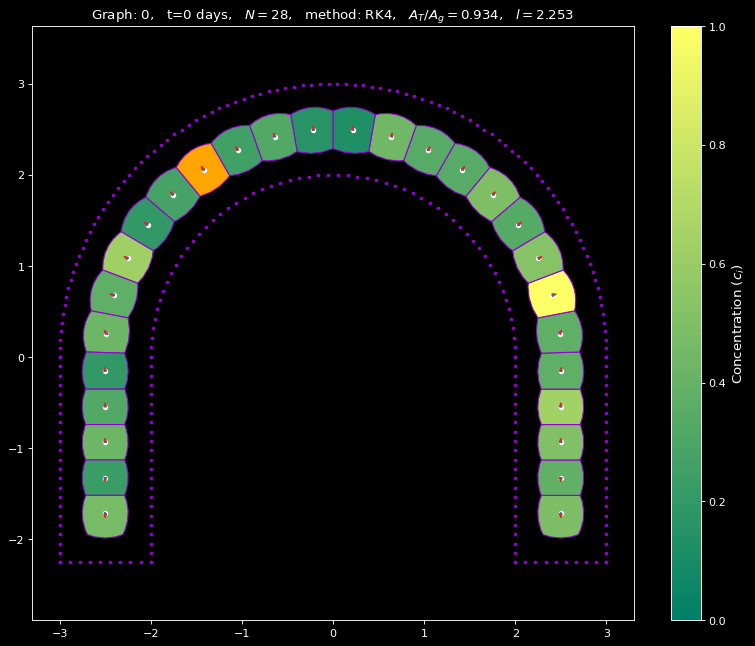

evolve_voronoi:  2 ,	 C_cells:  1 ,	 A_mean:  0.19873 ,	 A_std:  0.00817 Graph:  1
	T0: 0.0778 	 0.0985 	 0.1191
	C0: 0.123 	 0.3971 	 0.1722 	 1.0
	dl: 0 	 10 ,	 A_geo: 5.959276859237697


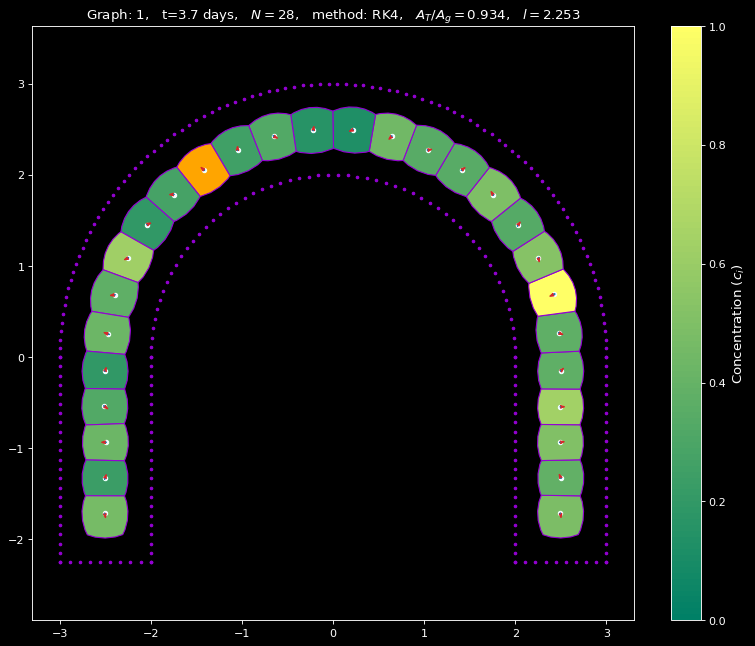

evolve_voronoi:  3 ,	 C_cells:  1 ,	 A_mean:  0.19874 ,	 A_std:  0.0078 Graph:  2
	T0: 0.1551 	 0.197 	 0.2369
	C0: 0.1229 	 0.3971 	 0.1722 	 1.0
	dl: 0 	 9 ,	 A_geo: 5.959276859237697


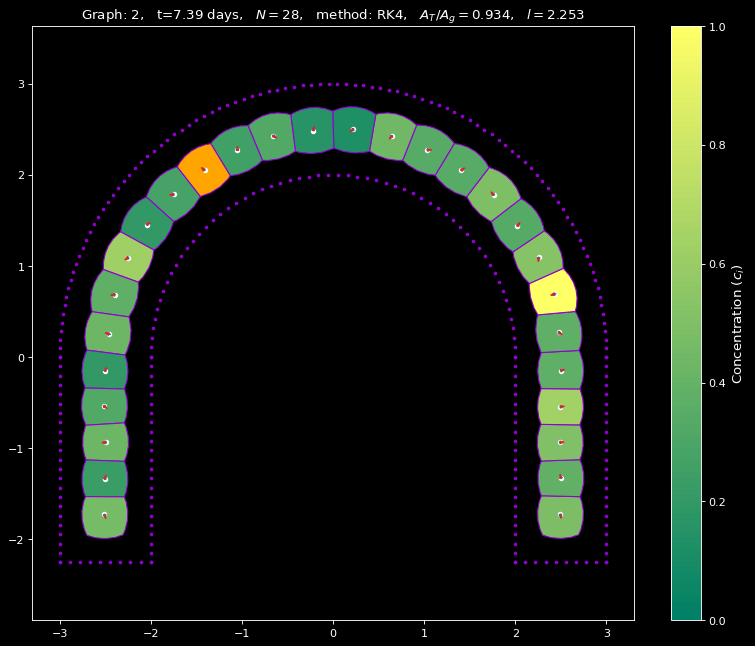

evolve_voronoi:  4 ,	 C_cells:  1 ,	 A_mean:  0.19897 ,	 A_std:  0.00732 Graph:  3
	T0: 0.2359 	 0.2957 	 0.3514
	C0: 0.1229 	 0.3971 	 0.1722 	 1.0
	dl: 0 	 8 ,	 A_geo: 5.959276859237697


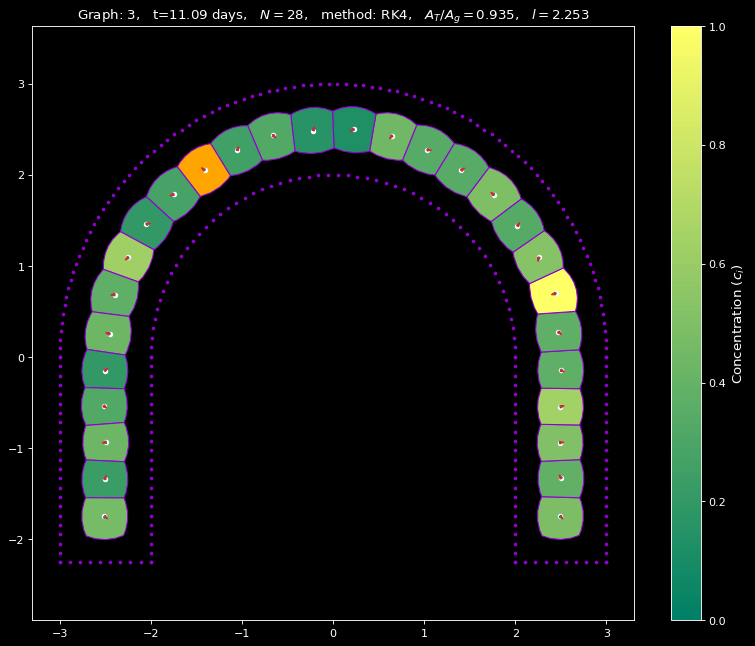

evolve_voronoi:  5 ,	 C_cells:  1 ,	 A_mean:  0.19934 ,	 A_std:  0.00669 Graph:  4
	T0: 0.3225 	 0.3943 	 0.4613
	C0: 0.1228 	 0.3971 	 0.1723 	 1.0
	dl: 0 	 7 ,	 A_geo: 5.959276859237697


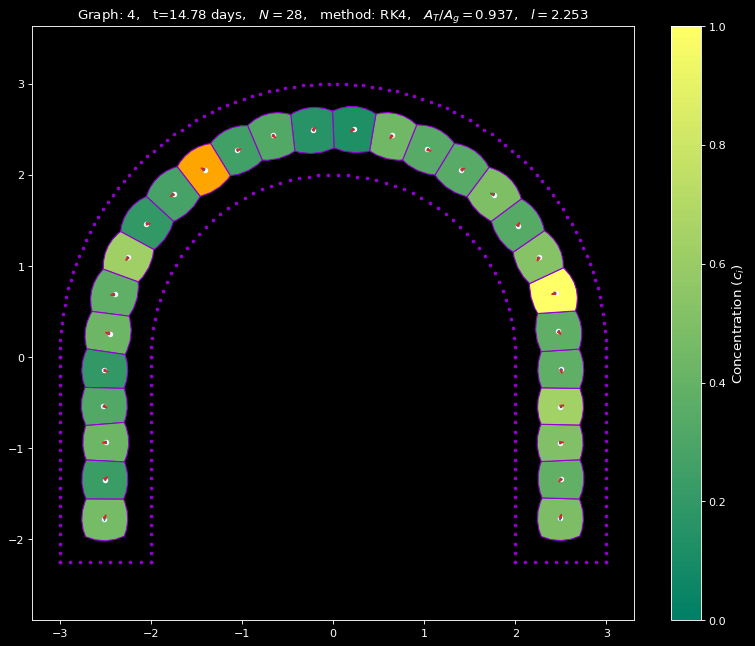

evolve_voronoi:  6 ,	 C_cells:  1 ,	 A_mean:  0.19975 ,	 A_std:  0.00598 Graph:  5
	T0: 0.4109 	 0.4929 	 0.5664
	C0: 0.1227 	 0.3971 	 0.1723 	 1.0
	dl: 0 	 6 ,	 A_geo: 5.959276859237697


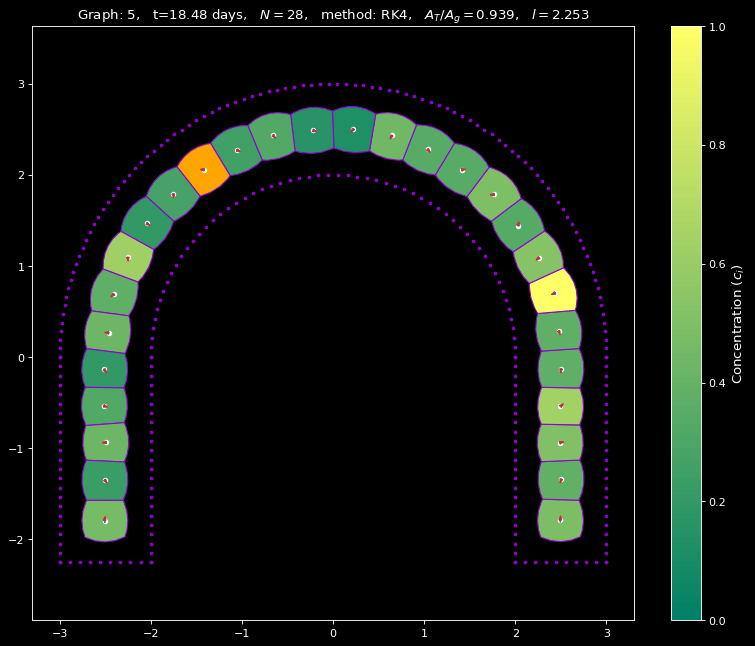

KeyboardInterrupt: ignored

In [80]:
plt.style.use('dark_background');
np.random.seed(42)

N = 28; l = 2.253
r = np.array([2, 3]); theta = np.array([0, np.pi])

K, params = [0.03, 0.25, 0.001], [1, 0.262985, 175]            #[k_area, k_centroid, k_vel], [alpha, beta, gamma]
# C0 = np.random.rand(N)
C0 = np.random.normal(0.41, 0.15, size=N); C0[np.random.randint(0,N,1)] = 1
C_cells = np.zeros(N); C_cells[np.random.randint(0,N,1)] = 1
# C_cells = np.zeros(N); C_cells[::6] = 0

structure_vor = get_structure(r, theta, l, 100)
# points_vor = rand_points(r, theta, l, N).T
points_vor = org_points(r, theta, l, N).T

vor_evo = mk_voronoi(points_vor, structure_vor)

filenames = [];
C_list = [];
evolve_vornonoi(r, theta, l, K, vor_evo, C0, C_cells, N, params,
                step=0.1, lenght=(1.95)*2*np.pi, iter=3060, vel=0.005, method="RK4", A_fixed=A_total(r, l, N, cols=1),
                scale=1/4, filenames=filenames, C_list=C_list, state=False, celldiv=True, l_evol=True, l_step=10, limits=(-0.34, 0.3))

In [ ]:
plt.style.use('default')
sns.set_style("darkgrid")

plt.figure(figsize=(6,5))
sns.kdeplot(C_list[0], color="darkviolet", bw_adjust=.4, linewidth=2)
sns.histplot(C_list[0], label="Concentración inicial", color="purple", binwidth=0.05, binrange=(-0.025,1.025), stat="density", alpha=0.4);
plt.ylabel("Frecuencia"); plt.xlabel("Concentración inicial");
plt.xlim([-0.05,1.05])
plt.show()

plt.figure(figsize=(6,5))
sns.kdeplot(C_list[-1], color="green", bw_adjust=.4, linewidth=2)
sns.histplot(C_list[-1], label='Concentración inicial' , color="green", binwidth=0.05, binrange=(-0.025,1.025), stat="density", alpha=0.3)
plt.ylabel("Frecuencia"); plt.xlabel("Concentración final");
plt.xlim([-0.05,1.05])
plt.show()

In [ ]:
with imageio.get_writer(f'/content/drive/MyDrive/biomath_model/inflammation_case_{N}_{K}.gif', fps=20) as writer:    # inputs: filename, frame per second
    for filename in filenames[:201]:
        image = imageio.imread(filename)                         # load the image file
        writer.append_data(image)                                # append the image file
print('Gif saved!\n')